In [11]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import warnings
from scipy.interpolate import CubicSpline

In [12]:
warnings.filterwarnings("ignore")

In [49]:
# Cubic spline Interpolation data inputation method
def four_ends_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        for i in range(4):
            column = first_filler(column, i, len(column) - 1 - i)
            column = last_filler(column, i, len(column) - 1 - i)
    return column

def four_ends_linear_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        size = len(column) - 1
        column = first_filler(column, 0, size)
        column = last_filler(column, 0, size)
        for i in range(0, 4):
            value = column.at[i]
            if i > 0 and (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_first = prev_valid_index(column, i)
                end_first = next_valid_index(column, i)
                gap = list(range(start_first + 1, end_first))
                linear_a = (column.at[end_first] - column.at[start_first])/(end_first - start_first)
                linear_b = column.at[start_first] - linear_a*start_first
                column.at[i] = linear_a*i + linear_b
            value = column.at[size - 4 + i]
            if i > 0 and (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_last = prev_valid_index(column, size - 4 + i)
                end_last = next_valid_index(column, size - 4 + i)
                gap = list(range(start_last + 1, end_last))
                linear_a = (column.at[end_last] - column.at[start_last])/(end_last - start_last)
                linear_b = column.at[start_last] - linear_a*start_last
                column.at[size - 4 + i] = linear_a*i + linear_b
    return column

def first_filler(column, init, end):
    if pd.isnull(column.at[init]) or np.isnan(column.at[init]):
        first_valid_index = 0
        while first_valid_index <= end and (pd.isnull(column.at[first_valid_index]) or 
                                             np.isnan(column.at[first_valid_index])):
            first_valid_index += 1
        if first_valid_index > end:
            column.at[init] = 0.0
        else:
            column.at[init] = column.at[first_valid_index]
    return column
    
def last_filler(column, init, end):
    if pd.isnull(column.at[end]) or np.isnan(column.at[end]):
        last_valid_index = len(column) -1
        while last_valid_index >= init and (pd.isnull(column.at[last_valid_index]) or 
                                         np.isnan(column.at[last_valid_index])):
            last_valid_index -= 1
        if last_valid_index < init:
            column.at[end] = 0.0
        else:
            column.at[end] = column.at[last_valid_index]
    return column
  
def neareast_four_indexes(column, start, end):
    return prev_four_valid_indexes(column, start) + next_four_valid_indexes(column, end)

def prev_four_valid_indexes(column, pos):
    prev_index = pos
    index_prev_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_prev_list[3 - i] = prev_index
            prev_index -= 1
            while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
                prev_index -= 1
    return index_prev_list  

def next_four_valid_indexes(column, pos):
    next_index = pos
    index_next_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_next_list[i] = next_index
            next_index += 1
            while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
                next_index += 1
    return index_next_list  

def prev_valid_index(column, pos):
    prev_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        prev_index -= 1
        while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
            prev_index -= 1
    return prev_index  

def next_valid_index(column, pos):
    next_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        next_index += 1
        while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
            next_index += 1
    return next_index

def interpolating_polynomial(nearest_indexes, nearest_values):
    coeffs = np.polyfit(nearest_indexes, nearest_values, len(nearest_indexes) - 1)
    return np.poly1d(coeffs)

def polynomial_filler(column):
    size = len(column) -1
    if column.isnull().any() and column.isna().any():
        for i, value in enumerate(column):
            if (i > 3 and i < size - 3) and (pd.isnull(value) or np.isnan(value) or (value == '')):
                nearest_values = []
                start = prev_valid_index(column, i)
                end = next_valid_index(column, i)
                gap = list(range(start + 1, end))
                nearest_indexes = neareast_four_indexes(column, start, end)
                for index in nearest_indexes:
                    nearest_values.append(column.at[index])
                polynomial = interpolating_polynomial(nearest_indexes, nearest_values)
                for x in gap:
                    column.at[x] = polynomial(x)
                plot_polynomial(polynomial, nearest_indexes[0], nearest_indexes[len(nearest_indexes) - 1], 50, gap, nearest_indexes, column.name)
    return column

def cubic_spline_filler(column):
    size = len(column) -1
    if column.isnull().any() and column.isna().any():
        for i, value in enumerate(column):
            if (i > 3 and i < size - 3) and (pd.isnull(value) or np.isnan(value) or (value == '')):
                nearest_values = []
                start = prev_valid_index(column, i)
                end = next_valid_index(column, i)
                gap = list(range(start + 1, end))
                nearest_indexes = neareast_four_indexes(column, start, end)
                for index in nearest_indexes:
                    nearest_values.append(column.at[index])
                cubic_spline = CubicSpline(nearest_indexes, nearest_values)
                for x in gap:
                    column.at[x] = cubic_spline(x)
                plot_polynomial(cubic_spline, nearest_indexes[0], nearest_indexes[len(nearest_indexes) - 1], 50, gap, nearest_indexes, column.name)
    return column

def plot_polynomial(polynomial, start, end, precision, interpolated_list, nearest_indexes, column_name):
    x = np.linspace(start, end, precision)
    y = polynomial(x)

    plt.figure()

    plt.plot(x, y)

    interpolated_x = interpolated_list  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='red')
    interpolated_x = nearest_indexes  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='green')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(column_name)

    plt.show()

In [50]:
def read_csv_replace_missing_by_polynomial(file_path):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path, skiprows=1)
        df = df.iloc[:, 2:-1]
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > 2:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = four_ends_filler(df[col])
                df[col] = polynomial_filler(df[col]) 
            i += 1
        return df

In [51]:
df = read_csv_replace_missing_by_polynomial('idh_educacao.csv')
df = df.T
df
header = df.iloc[0]
df = df[1:]
df.columns = header
df

Estado,Acre,Alagoas,Amazonas,Amapá,Bahia,Ceará,Distrito Federal,Espírito Santo,Goiás,Maranhão,...,Paraná,Rio de Janeiro,Rio Grande do Norte,Rondônia,Roraima,Rio Grande do Sul,Santa Catarina,Sergipe,São Paulo,Tocantins
1970,0.343,0.285,0.462,0.49,0.359,0.325,0.647,0.495,0.469,0.292,...,0.505,0.645,0.334,0.472,0.49,0.614,0.6,0.339,0.615,0.342
1980,0.417,0.348,0.54,0.578,0.426,0.411,0.726,0.582,0.564,0.363,...,0.605,0.697,0.422,0.511,0.566,0.675,0.667,0.405,0.674,0.423
1991,0.518,0.442,0.605,0.645,0.511,0.502,0.774,0.661,0.653,0.458,...,0.677,0.749,0.519,0.622,0.618,0.725,0.722,0.515,0.729,0.534
2012,0.649,0.587,0.632,0.659,0.593,0.667,0.768,0.692,0.698,0.611,...,0.718,0.703,0.617,0.637,0.746,0.674,0.74,0.607,0.792,0.676
2013,0.658,0.573,0.659,0.714,0.594,0.667,0.794,0.701,0.71,0.639,...,0.737,0.715,0.642,0.612,0.735,0.691,0.757,0.598,0.8,0.691
2014,0.679,0.599,0.667,0.688,0.619,0.679,0.791,0.709,0.723,0.639,...,0.747,0.736,0.668,0.627,0.757,0.699,0.768,0.625,0.813,0.729
2015,0.679,0.605,0.686,0.69,0.64,0.689,0.789,0.726,0.722,0.649,...,0.747,0.752,0.683,0.664,0.758,0.717,0.769,0.633,0.811,0.707
2016,0.704,0.635,0.705,0.709,0.656,0.708,0.822,0.732,0.754,0.673,...,0.773,0.757,0.676,0.691,0.771,0.722,0.785,0.625,0.837,0.723
2017,0.671,0.634,0.732,0.7,0.655,0.715,0.797,0.731,0.743,0.684,...,0.764,0.762,0.677,0.699,0.764,0.727,0.778,0.639,0.826,0.729
2018,0.706,0.651,0.717,0.742,0.66,0.74,0.808,0.743,0.757,0.685,...,0.777,0.781,0.69,0.705,0.774,0.736,0.78,0.66,0.829,0.741


In [52]:
df['Ano'] = df.index
df = df.reset_index(drop=True)

missing_years = list(range(1981, 1991)) + list(range(1992, 2013))
for year in missing_years: 
    novo_ano = pd.Series({'Ano': year})
    df = df.append(novo_ano, ignore_index=True)
    
df['Ano'] = df['Ano'].astype(int)    
df = df.sort_values('Ano', ascending=True)
df = df.set_index('Ano')
df.to_csv('idh_para_interpolacao.csv', index=True)
df

,Acre,Alagoas,Amazonas,Amapá,Bahia,Ceará,Distrito Federal,Espírito Santo,Goiás,Maranhão,...,Paraná,Rio de Janeiro,Rio Grande do Norte,Rondônia,Roraima,Rio Grande do Sul,Santa Catarina,Sergipe,São Paulo,Tocantins
Ano,,,,,,,,,,,,,,,,,,,,,
1970,0.343,0.285,0.462,0.49,0.359,0.325,0.647,0.495,0.469,0.292,...,0.505,0.645,0.334,0.472,0.49,0.614,0.6,0.339,0.615,0.342
1980,0.417,0.348,0.54,0.578,0.426,0.411,0.726,0.582,0.564,0.363,...,0.605,0.697,0.422,0.511,0.566,0.675,0.667,0.405,0.674,0.423
1981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
def read_csv_replace_missing_by_polynomial_2(file_path):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path)
        df = df.iloc[:, :-1]
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > 0:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = four_ends_linear_filler(df[col])
                df[col] = cubic_spline_filler(df[col]) 
            i += 1
        return df

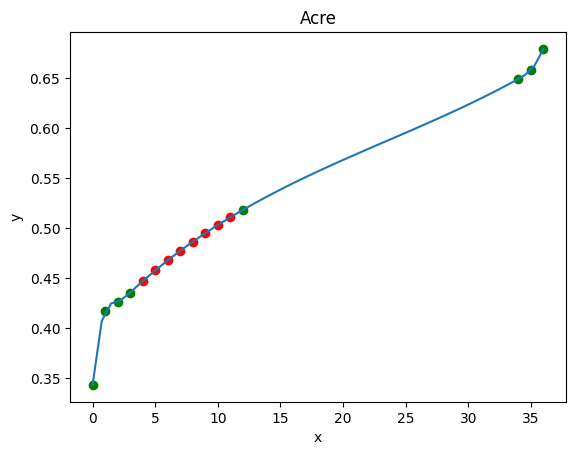

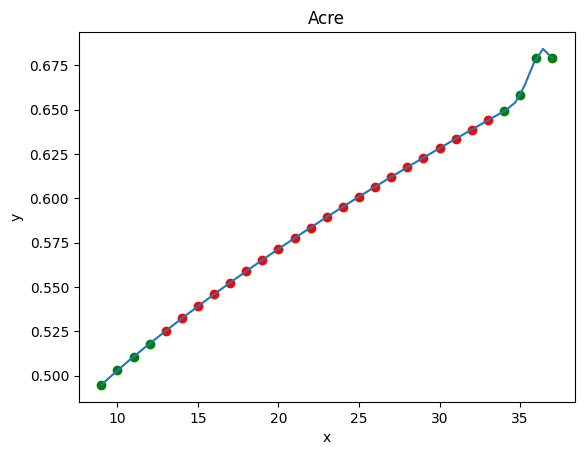

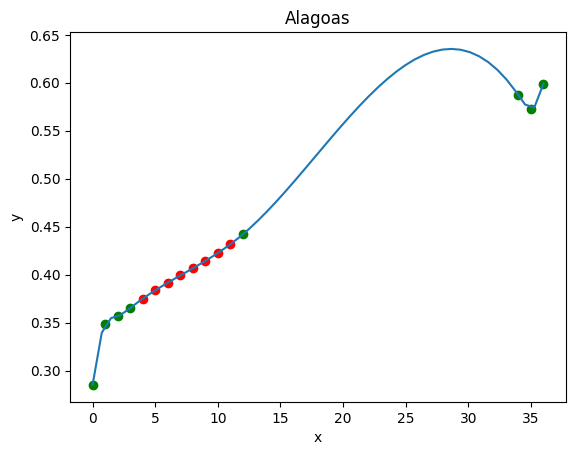

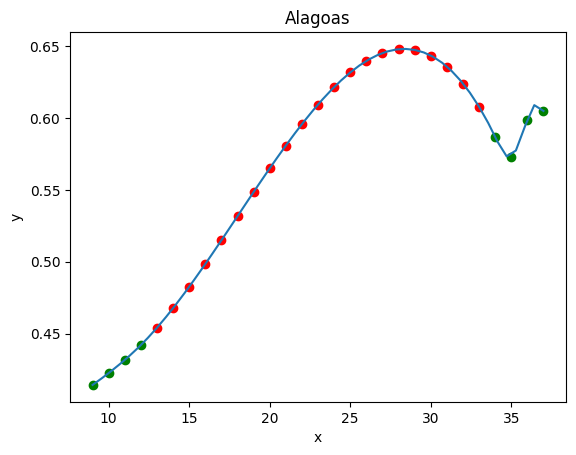

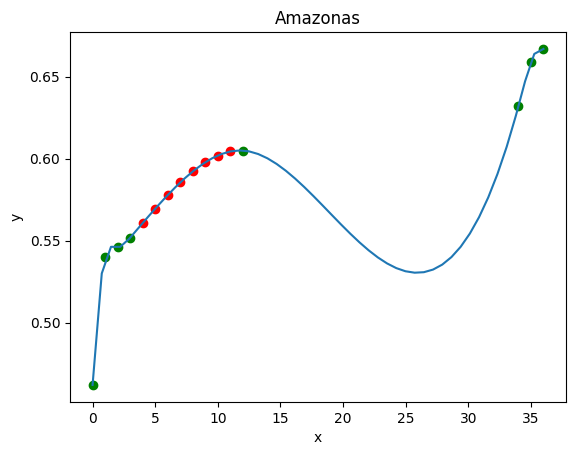

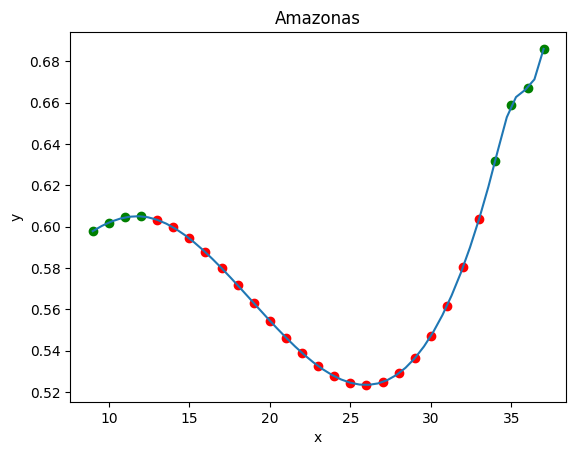

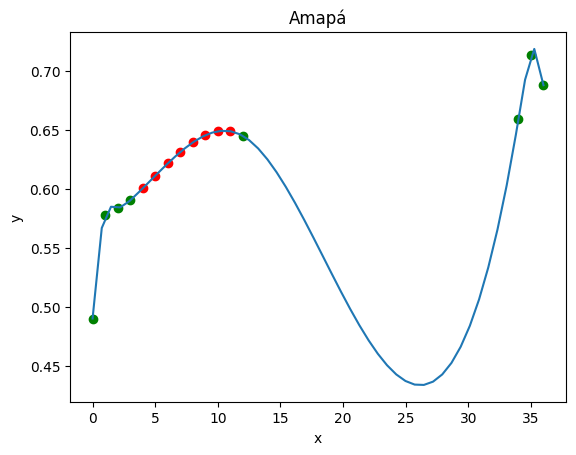

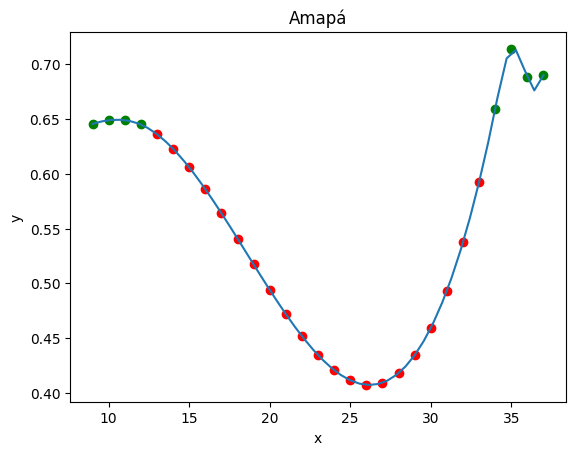

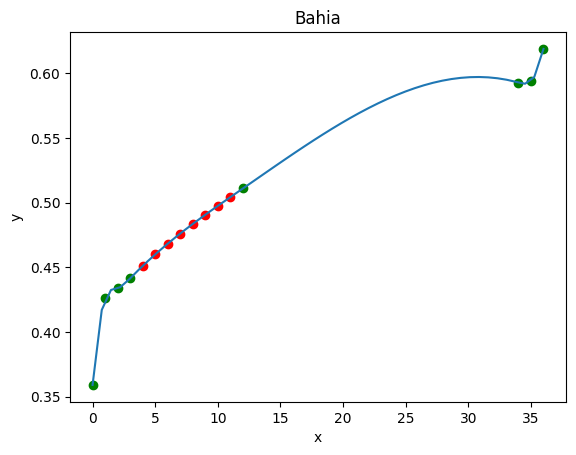

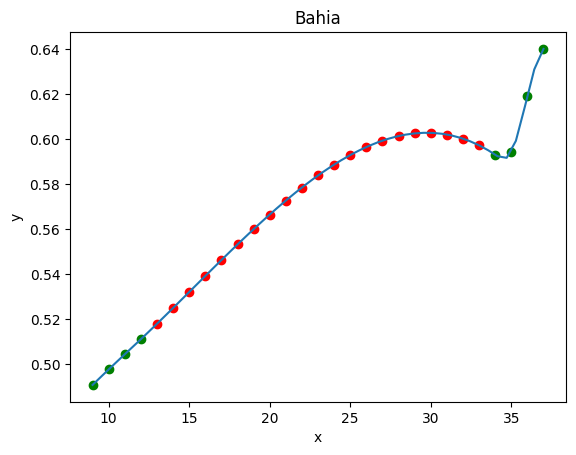

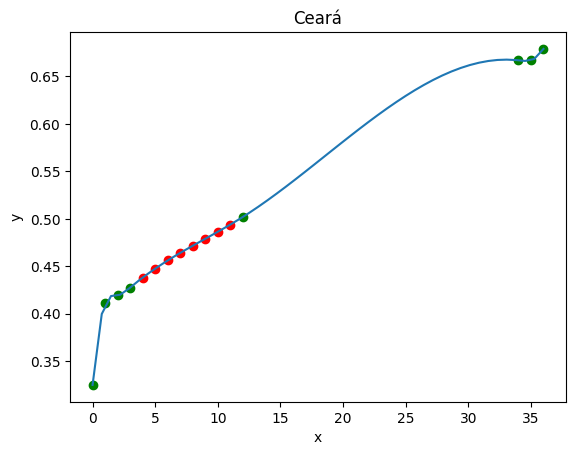

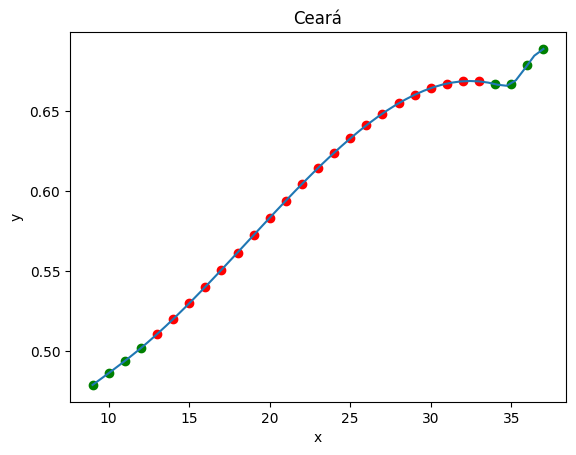

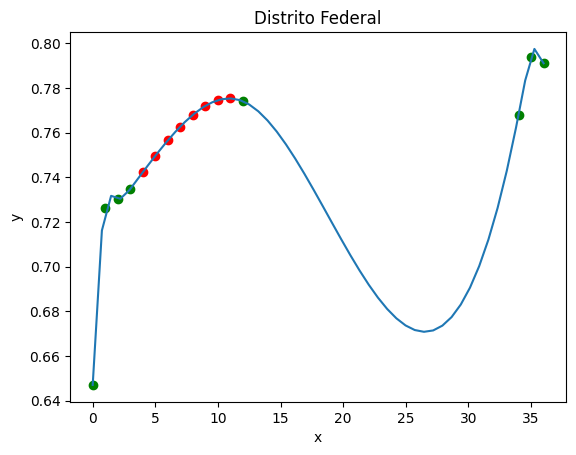

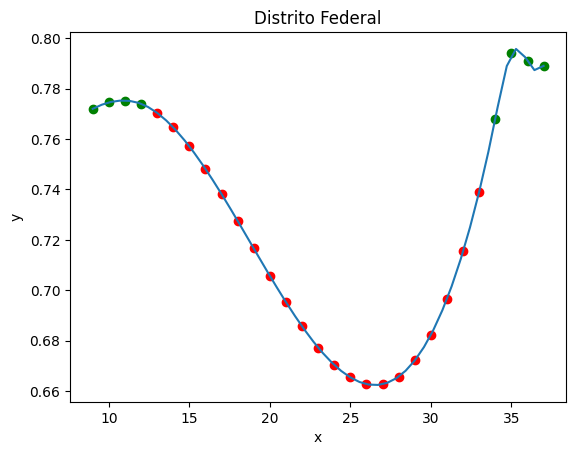

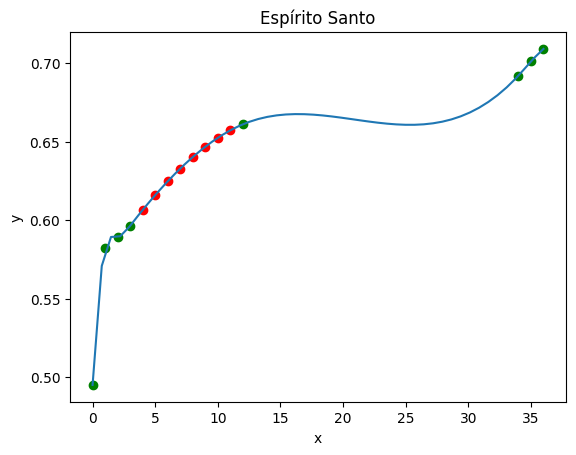

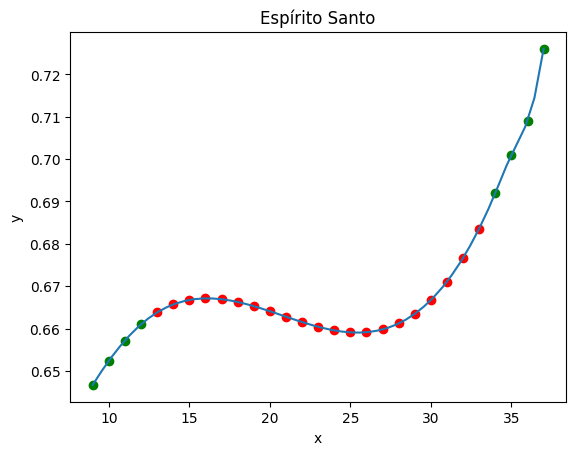

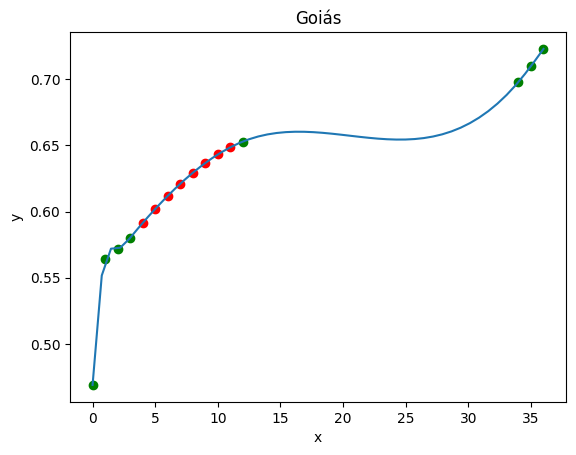

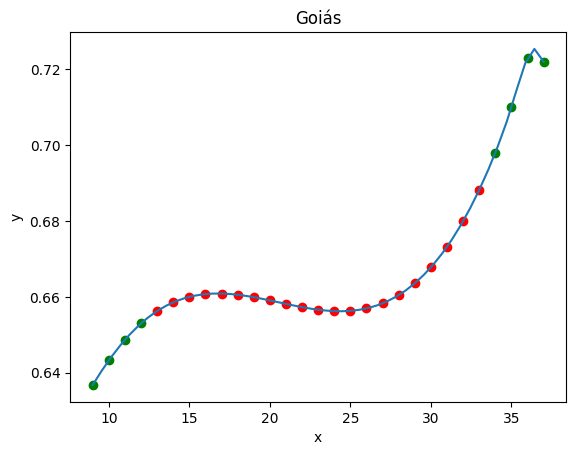

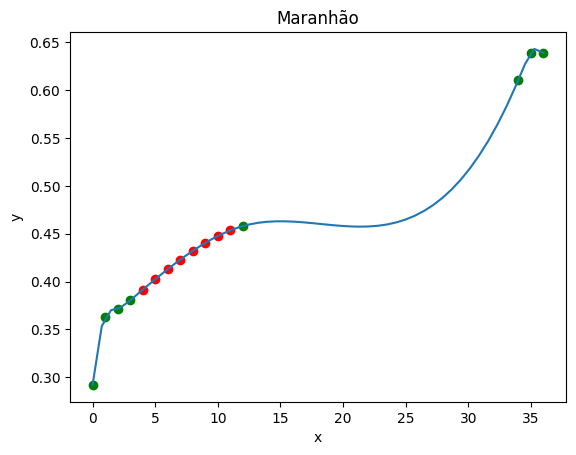

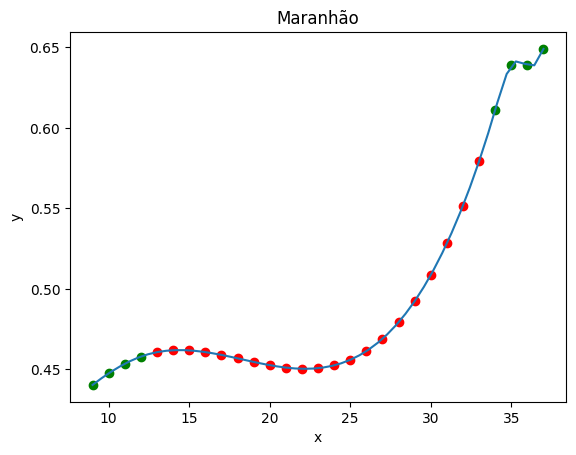

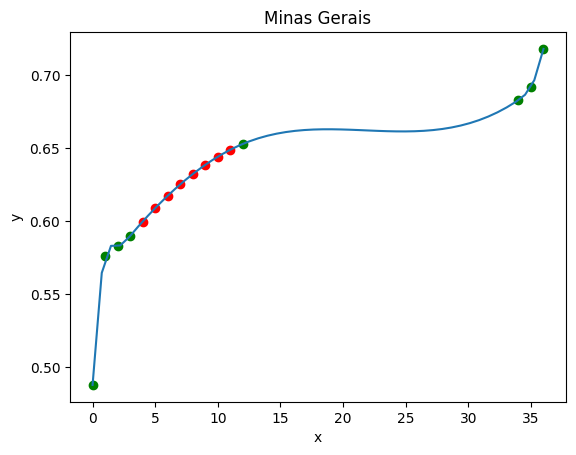

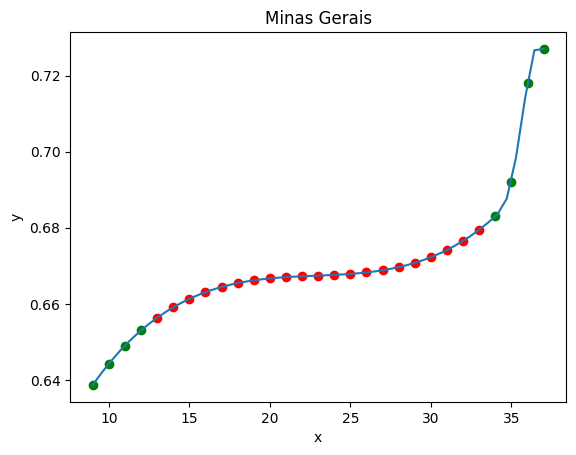

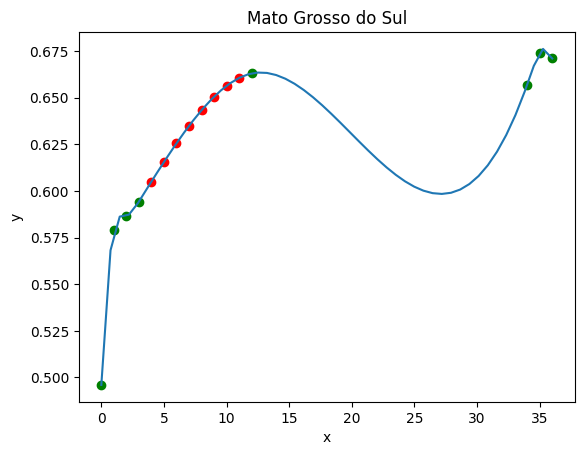

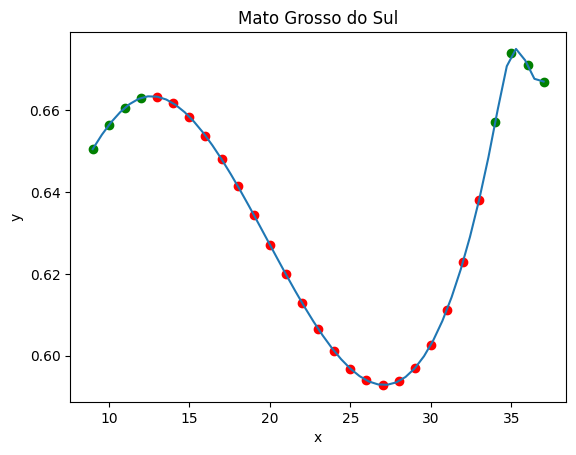

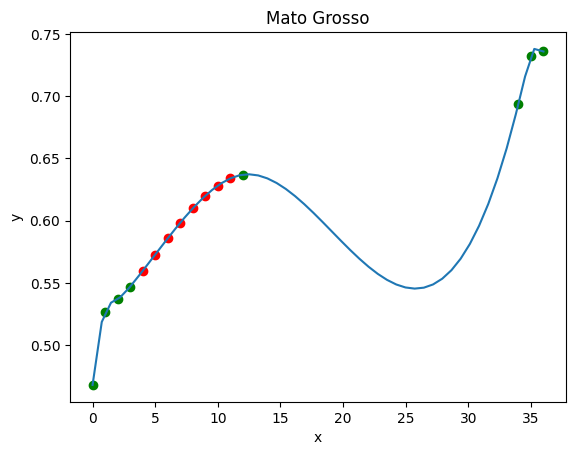

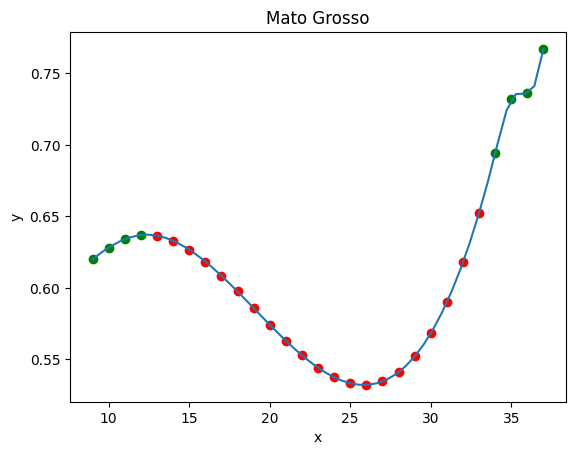

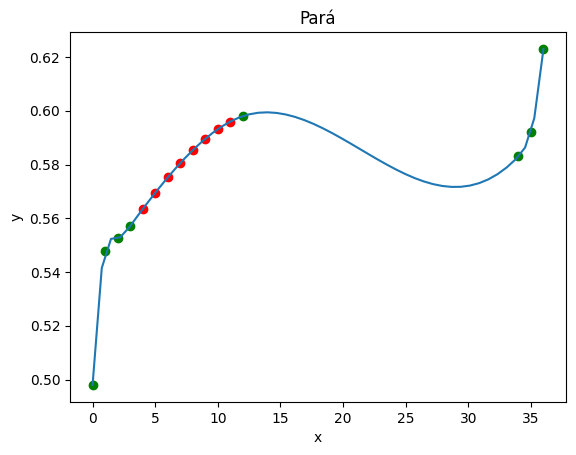

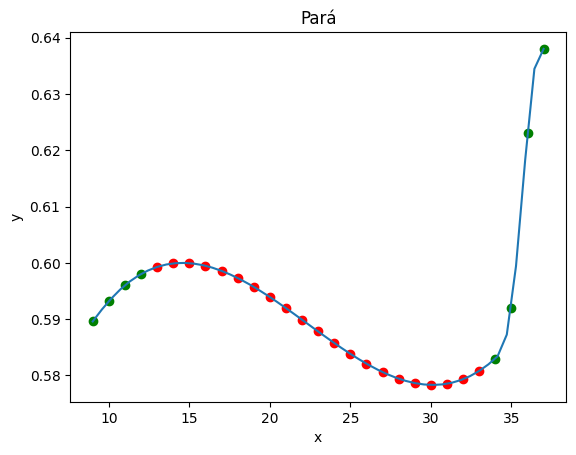

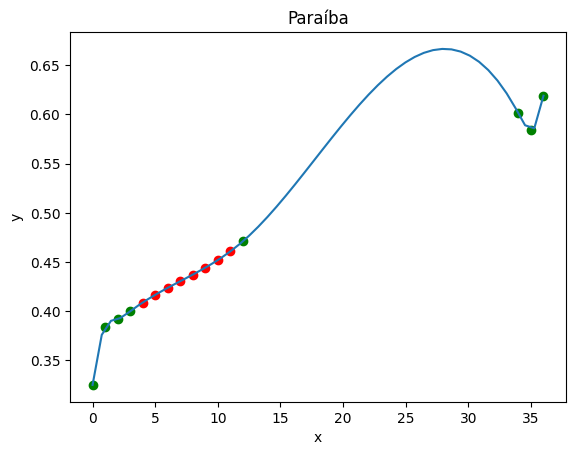

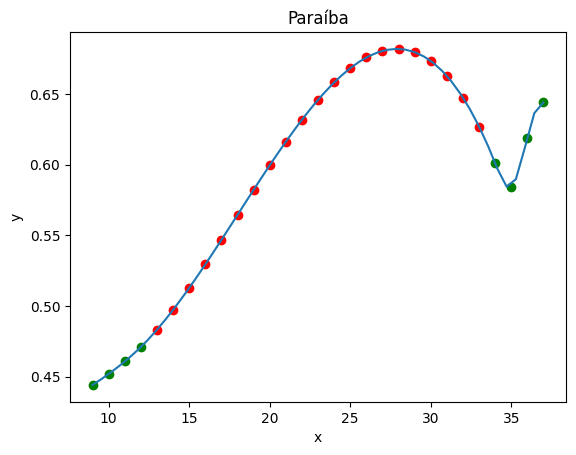

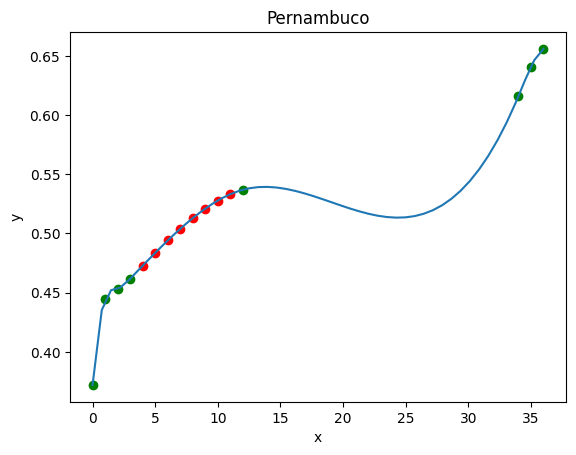

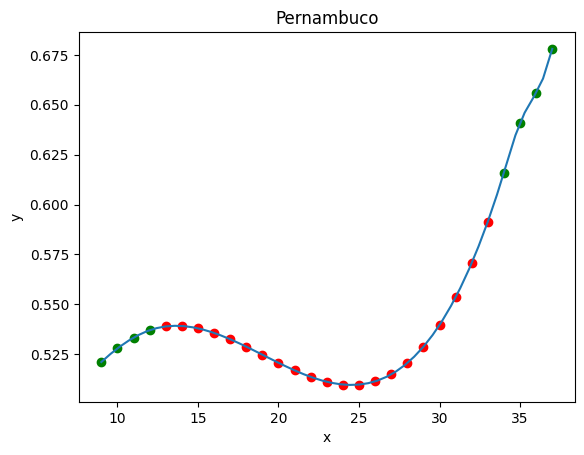

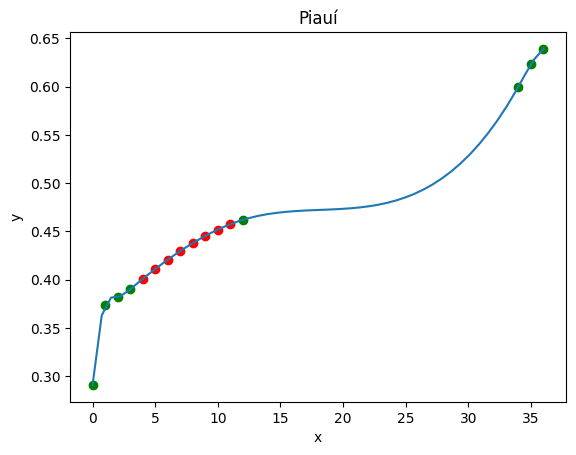

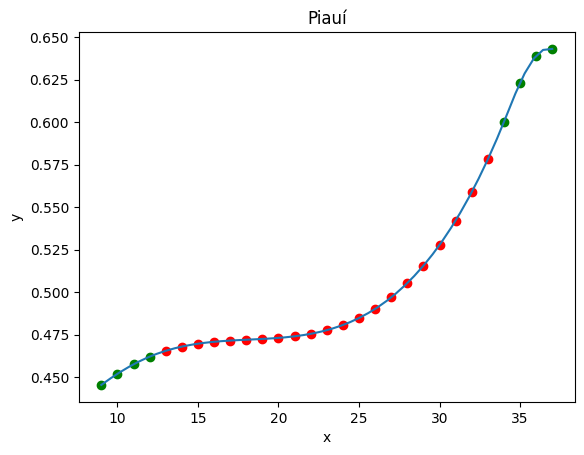

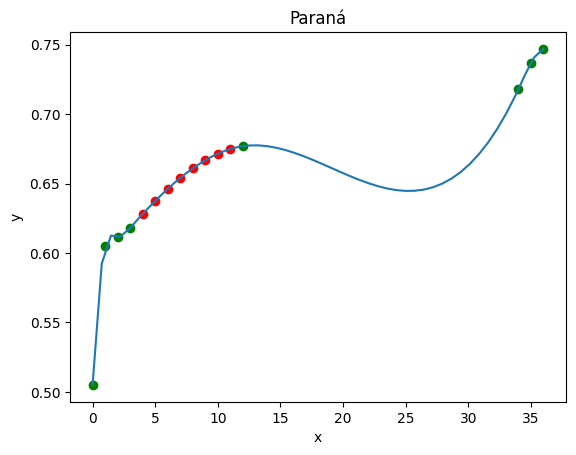

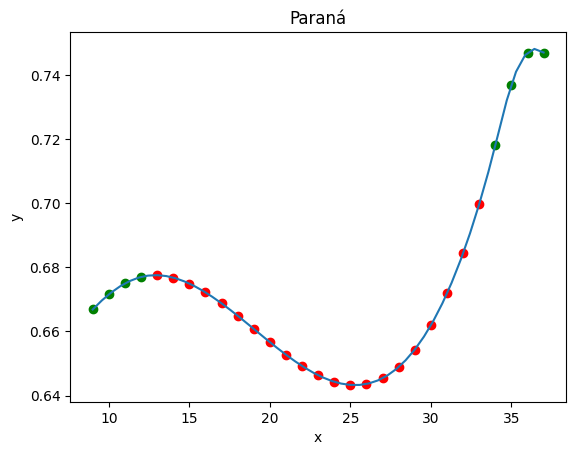

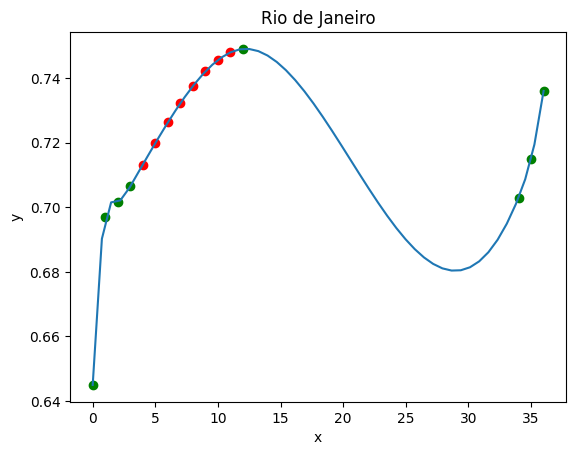

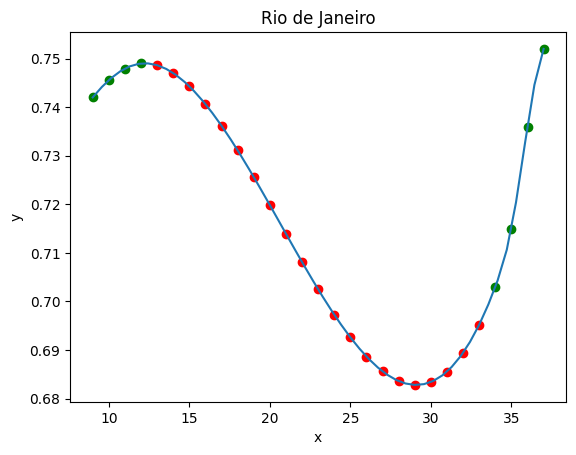

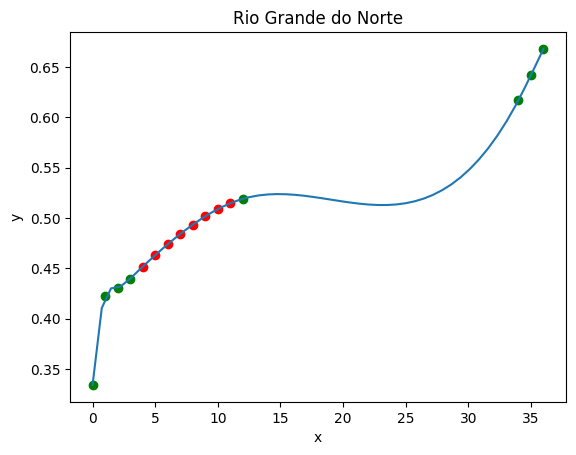

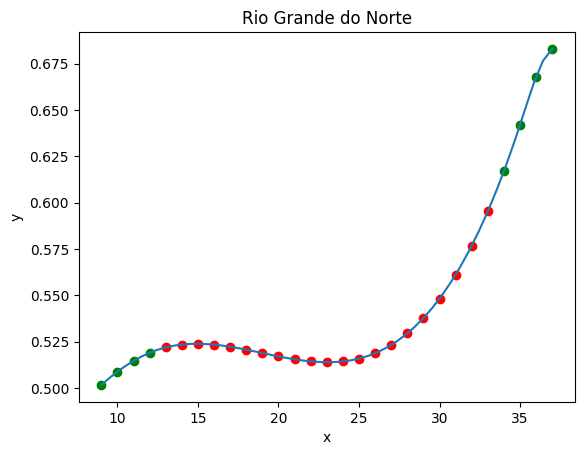

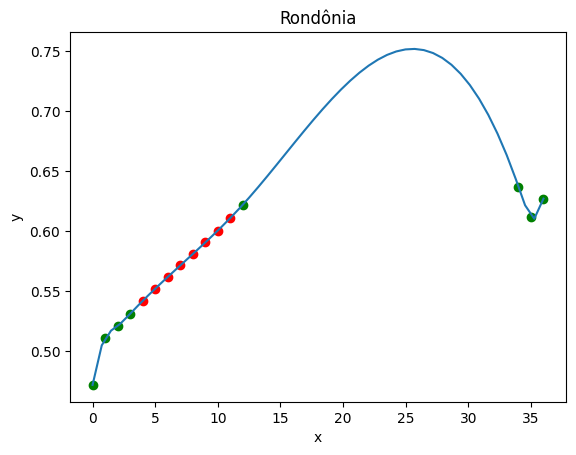

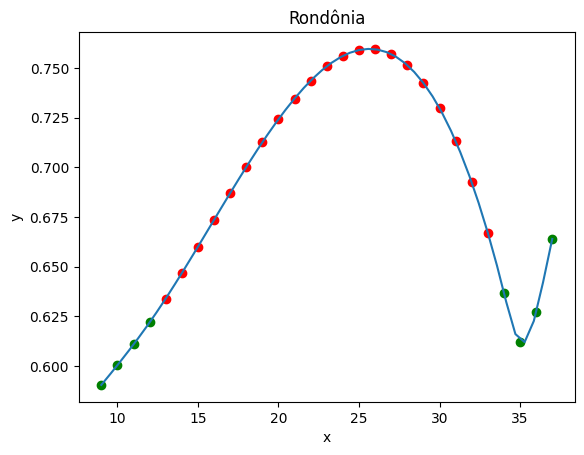

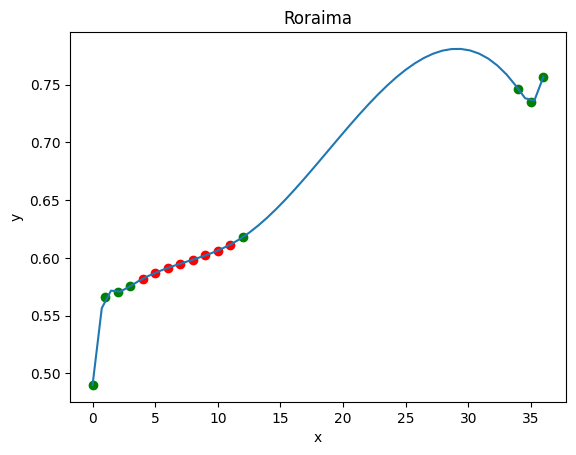

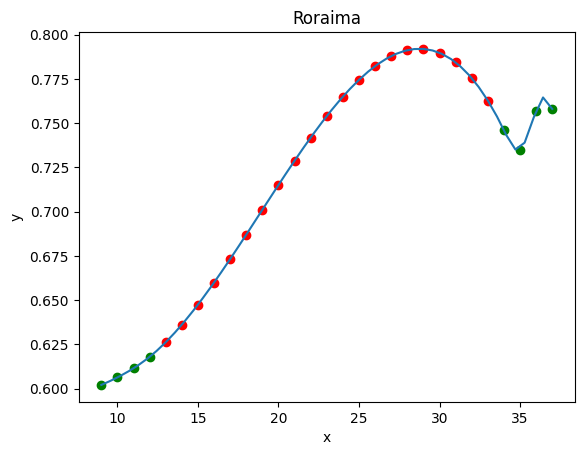

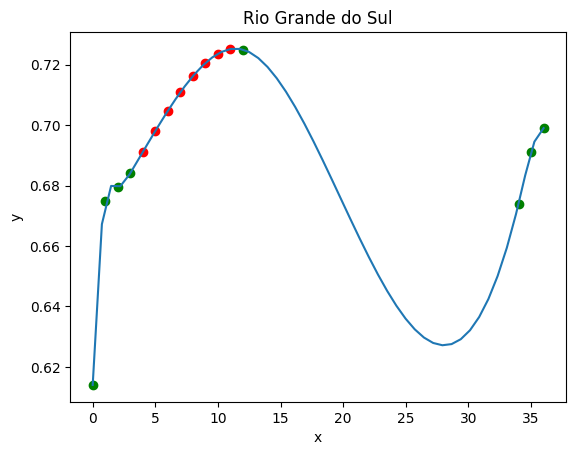

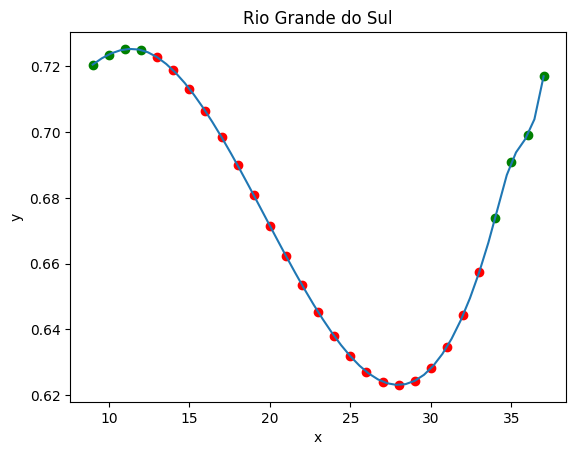

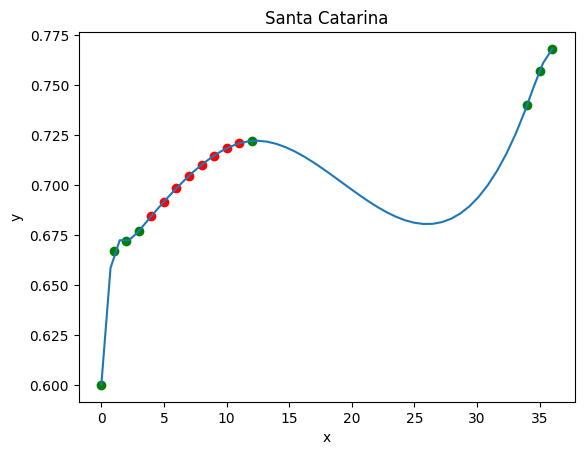

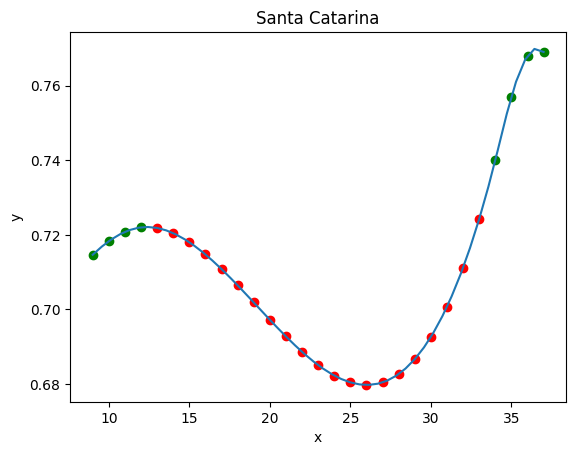

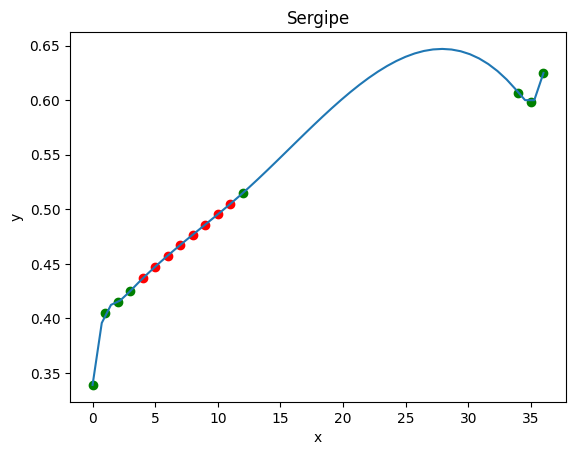

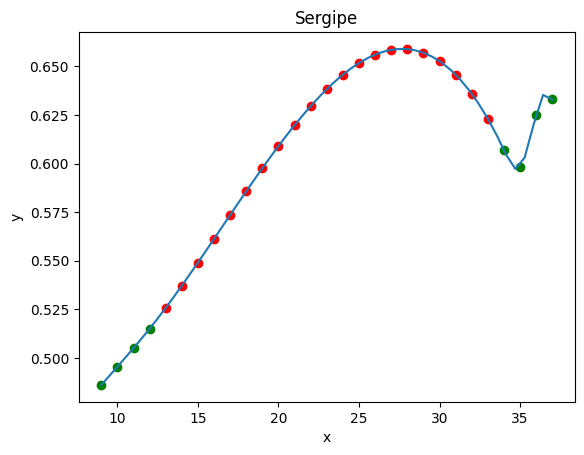

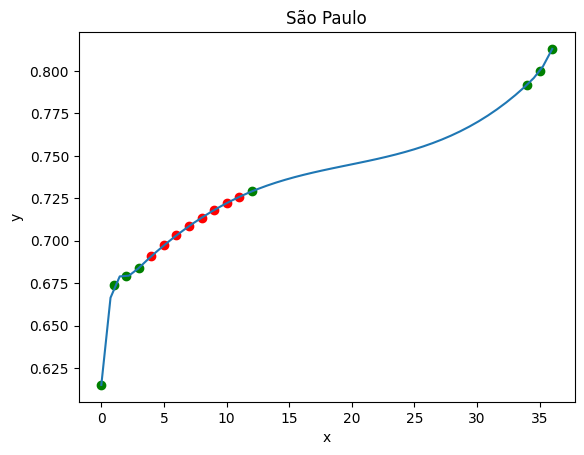

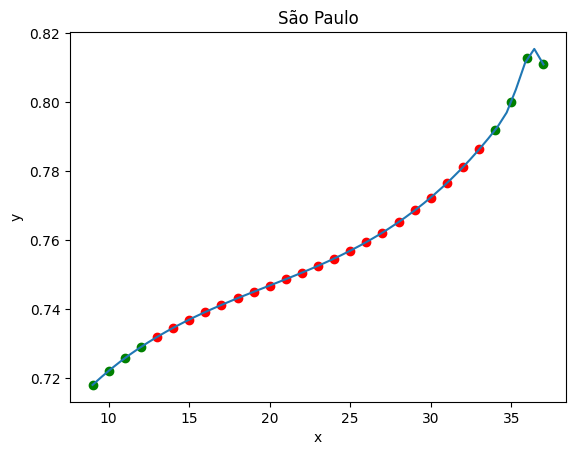

,Acre,Alagoas,Amazonas,Amapá,Bahia,Ceará,Distrito Federal,Espírito Santo,Goiás,Maranhão,...,Piauí,Paraná,Rio de Janeiro,Rio Grande do Norte,Rondônia,Roraima,Rio Grande do Sul,Santa Catarina,Sergipe,São Paulo
Ano,,,,,,,,,,,,,,,,,,,,,
1970,0.343000,0.285000,0.462000,0.490000,0.359000,0.325000,0.647000,0.495000,0.469000,0.292000,...,0.291000,0.505000,0.645000,0.334000,0.472000,0.490000,0.614000,0.600000,0.339000,0.615000
1980,0.417000,0.348000,0.540000,0.578000,0.426000,0.411000,0.726000,0.582000,0.564000,0.363000,...,0.374000,0.605000,0.697000,0.422000,0.511000,0.566000,0.675000,0.667000,0.405000,0.674000
1981,0.426182,0.356545,0.545909,0.584091,0.433727,0.419273,0.730364,0.589182,0.572091,0.371636,...,0.382000,0.611545,0.701727,0.430818,0.521091,0.570727,0.679545,0.672000,0.415000,0.679000
1982,0.435364,0.365091,0.551818,0.590182,0.441455,0.427545,0.734727,0.596364,0.580182,0.380273,...,0.390000,0.618091,0.706455,0.439636,0.531182,0.575455,0.684091,0.677000,0.425000,0.684000
1983,0.446717,0.374860,0.560751,0.600421,0.451057,0.438074,0.742235,0.606427,0.591427,0.391438,...,0.400766,0.628115,0.713194,0.451512,0.541915,0.581899,0.691102,0.684451,0.436598,0.690855
1984,0.457435,0.383566,0.569511,0.611092,0.459980,0.447533,0.749577,0.615889,0.602032,0.402378,...,0.411017,0.637528,0.719846,0.462966,0.552077,0.587054,0.698064,0.691622,0.447402,0.697221
1985,0.467556,0.391532,0.577848,0.621565,0.468313,0.456139,0.756487,0.624698,0.611934,0.412918,...,0.420679,0.646219,0.726232,0.473851,0.561843,0.591287,0.704734,0.698371,0.457581,0.703109
1986,0.477121,0.399085,0.585513,0.631211,0.476148,0.464109,0.762700,0.632804,0.621068,0.422885,...,0.429674,0.654077,0.732175,0.484021,0.571390,0.594968,0.710868,0.704554,0.467303,0.708528
1987,0.486169,0.406548,0.592255,0.639400,0.483574,0.471659,0.767949,0.640155,0.629371,0.432102,...,0.437928,0.660992,0.737496,0.493329,0.580894,0.598466,0.716224,0.710030,0.476739,0.713492


In [54]:
df = read_csv_replace_missing_by_polynomial_2('idh_para_interpolacao.csv')
df = df.set_index('Ano')
df

In [41]:
def plot_column(column, color):
    plt.figure(figsize=(12, 6))
    plt.plot(column.index, column.values, color=color)
    plt.xlabel(column.index.name)
    plt.ylabel('IDH - educação')
    plt.title(column.name)  # Set the column name as the graph title
    plt.xticks(rotation=45)
    plt.show()

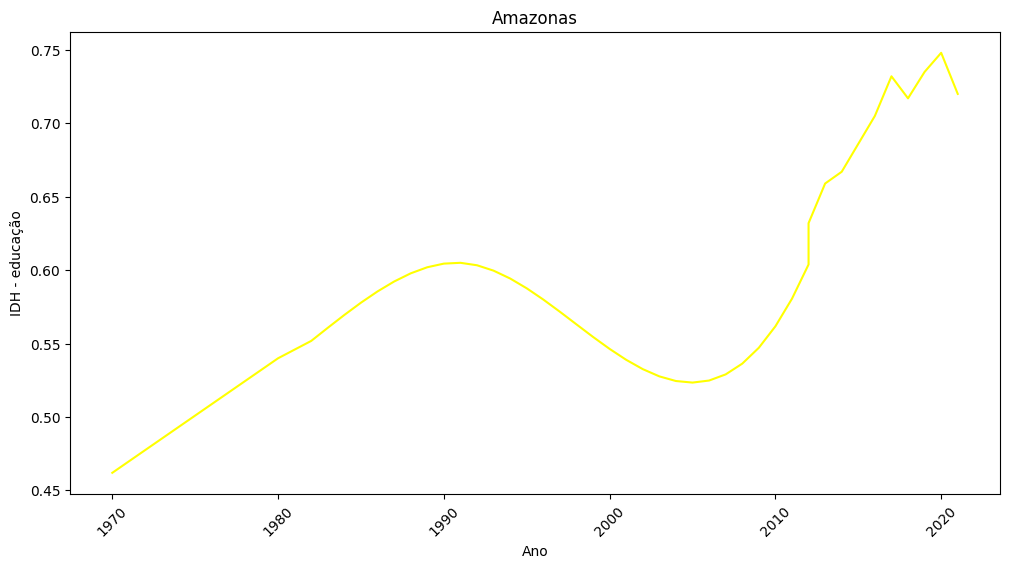

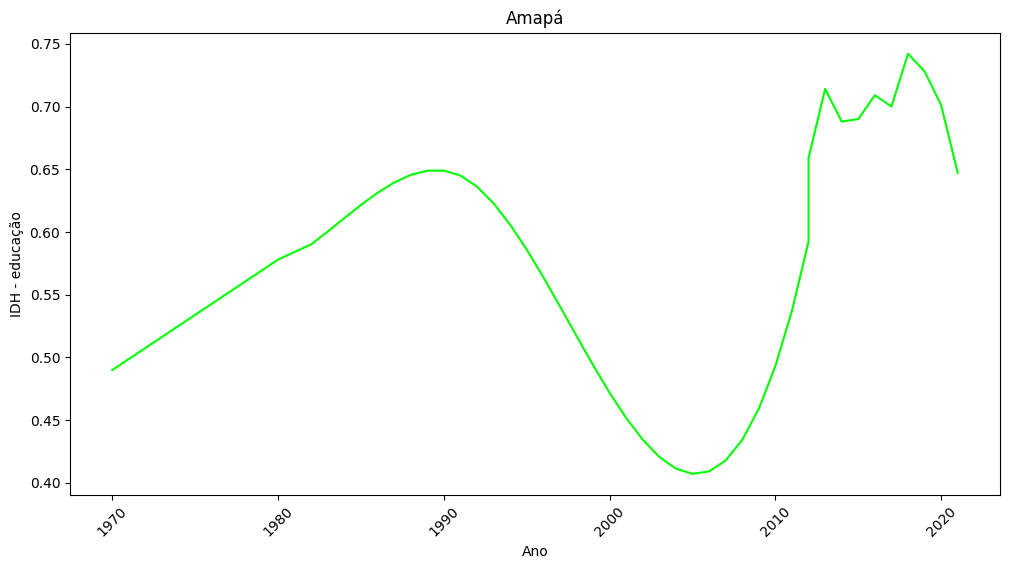

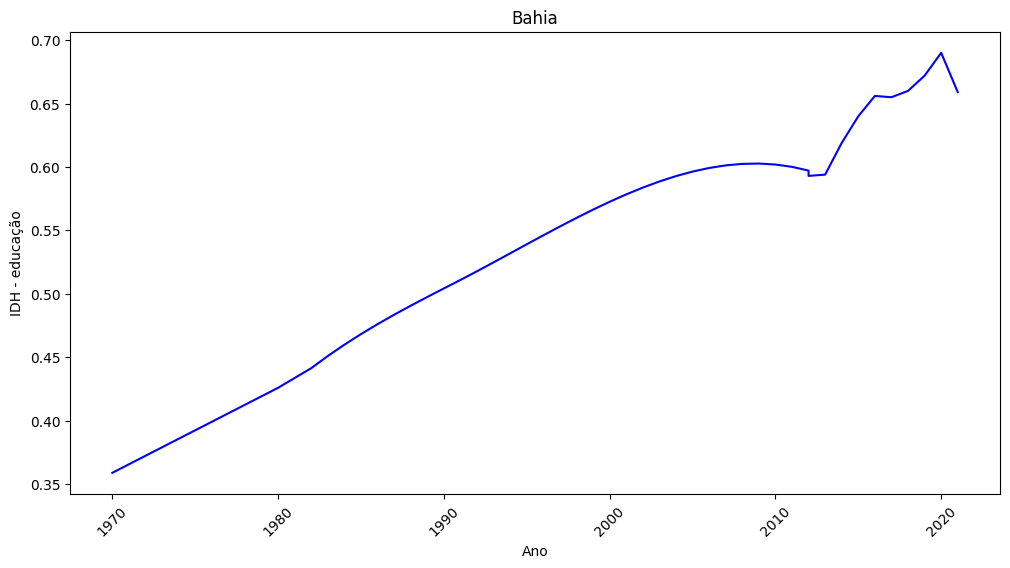

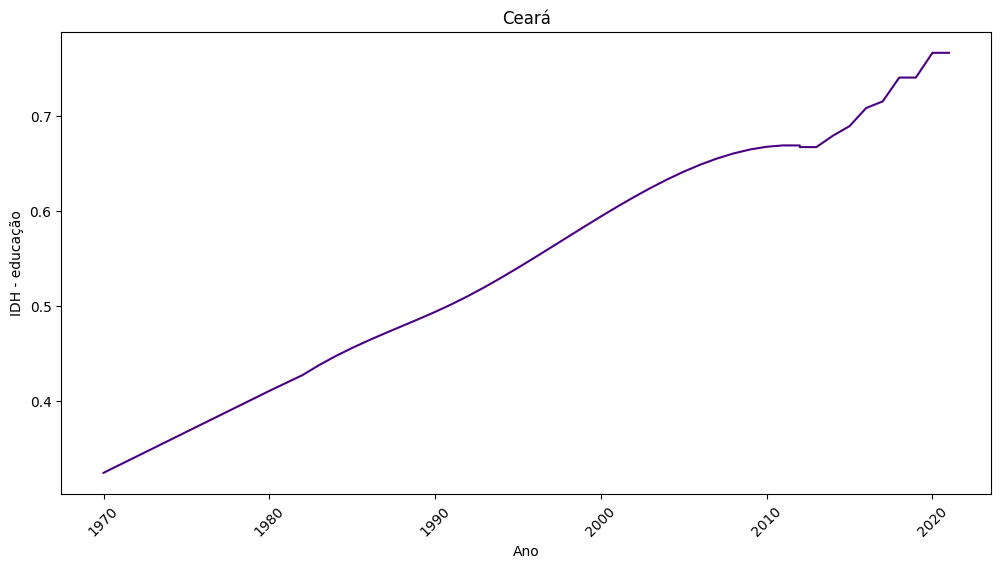

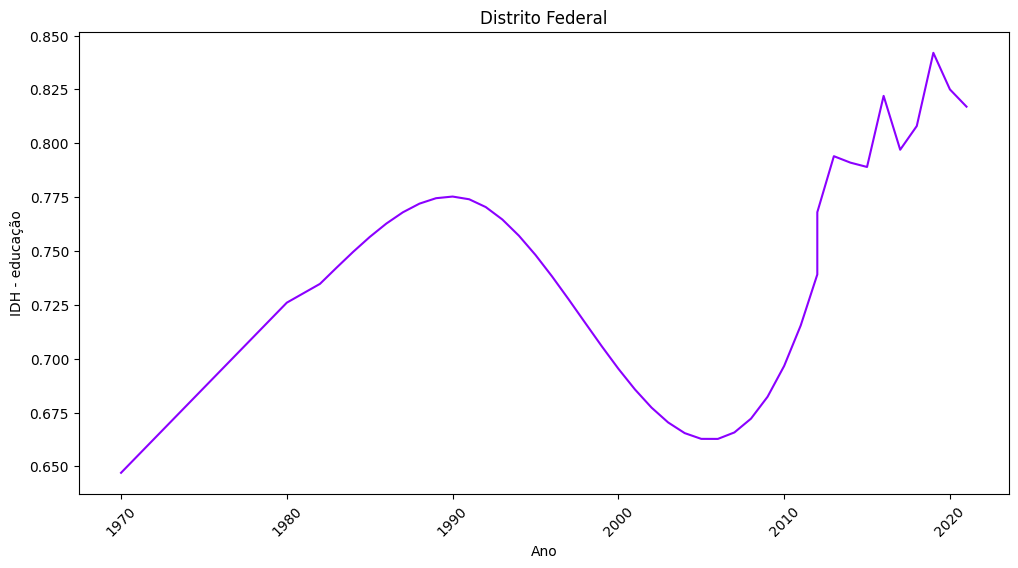

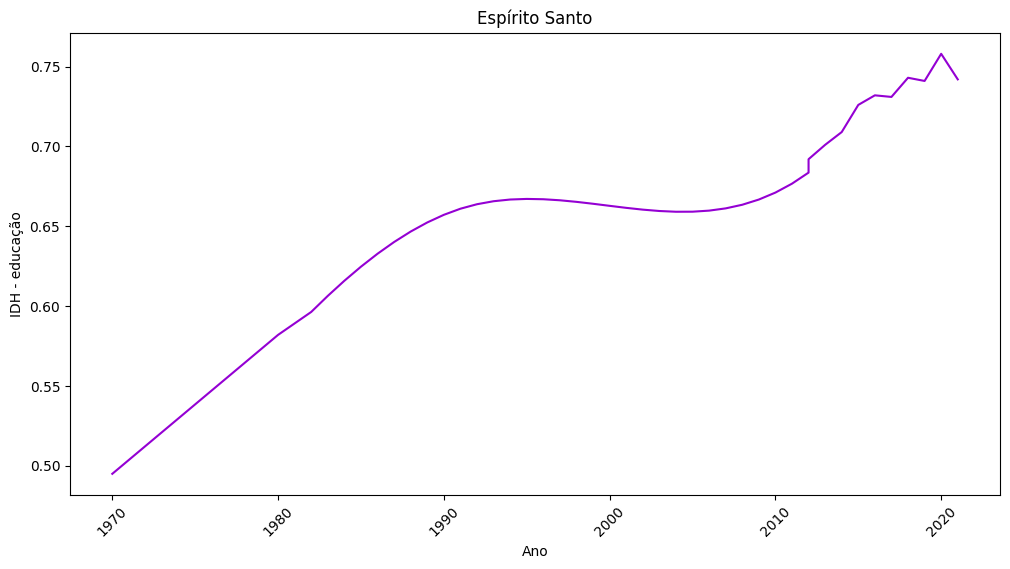

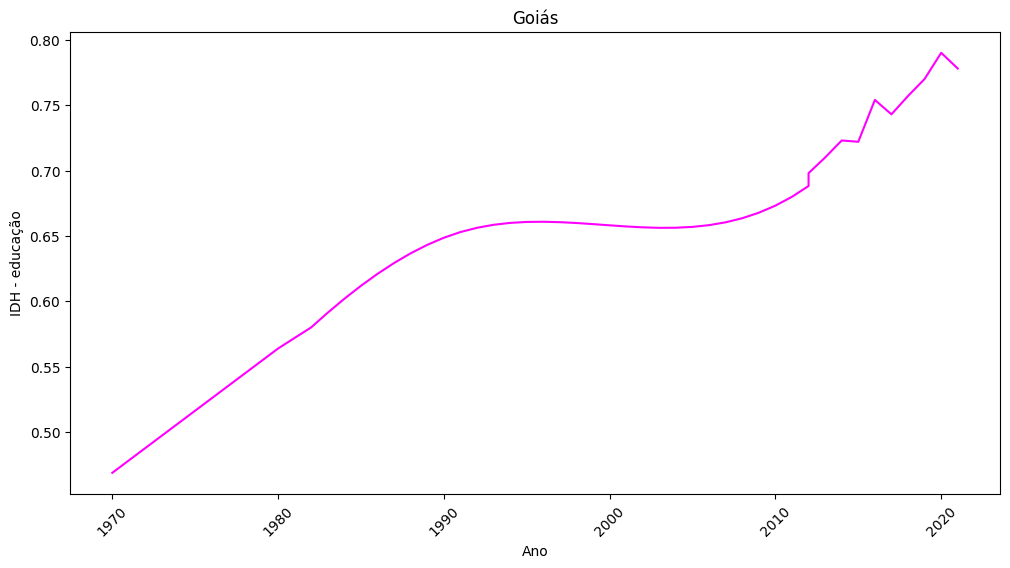

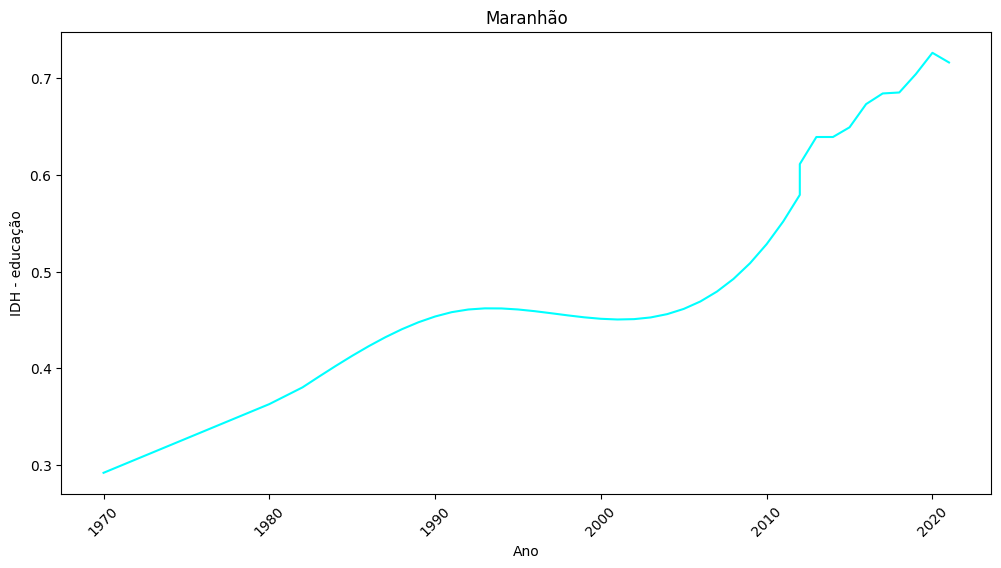

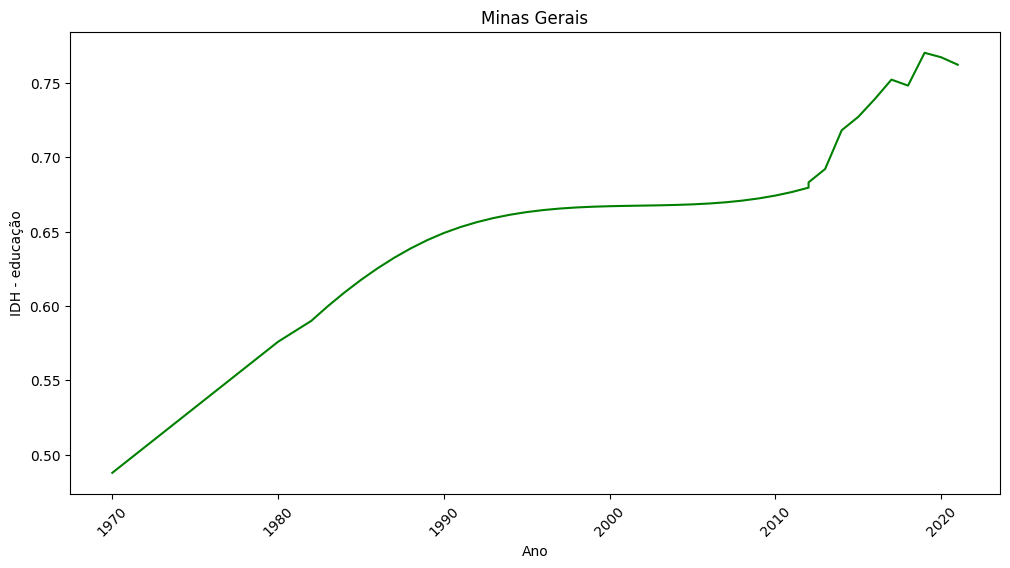

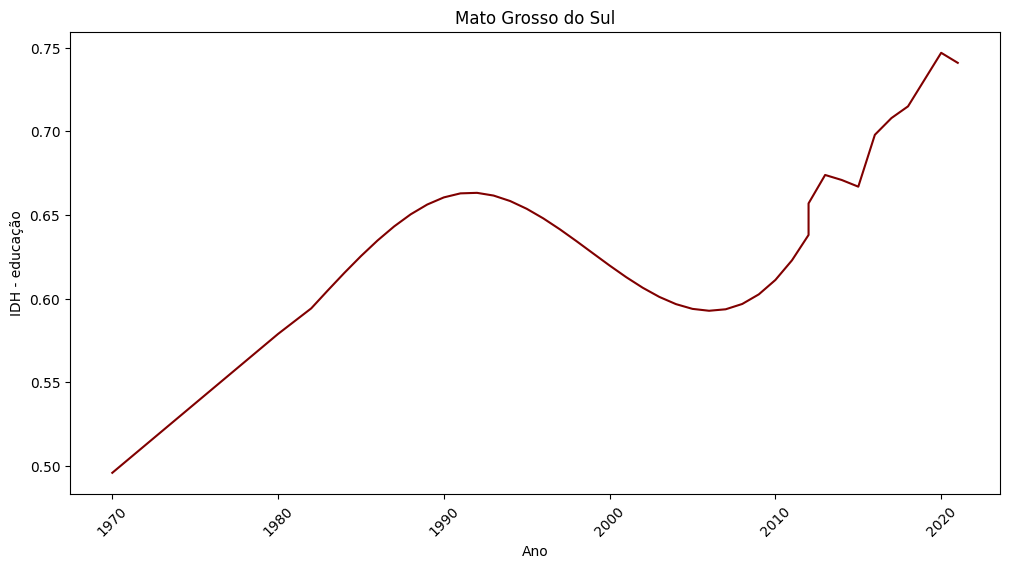

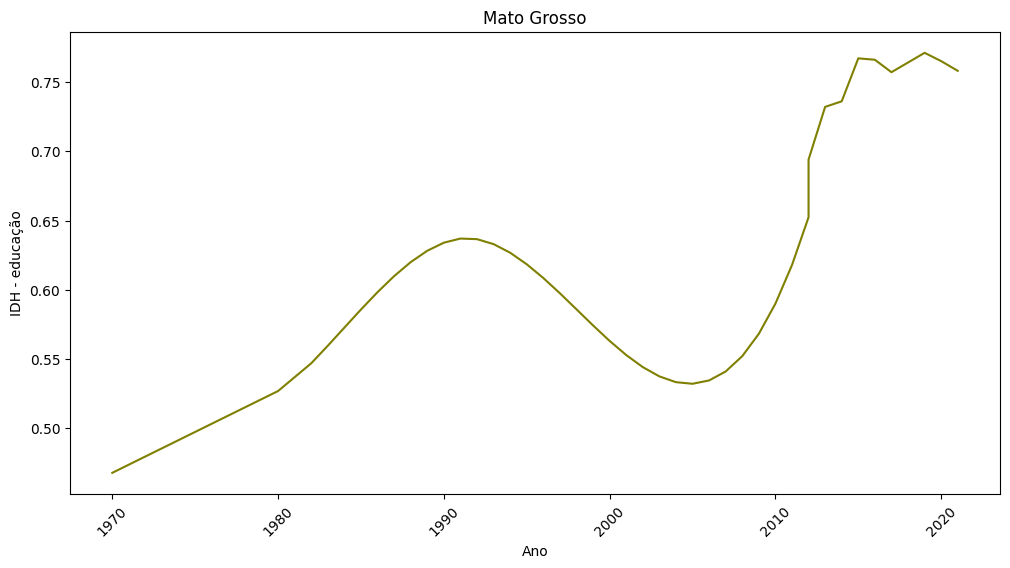

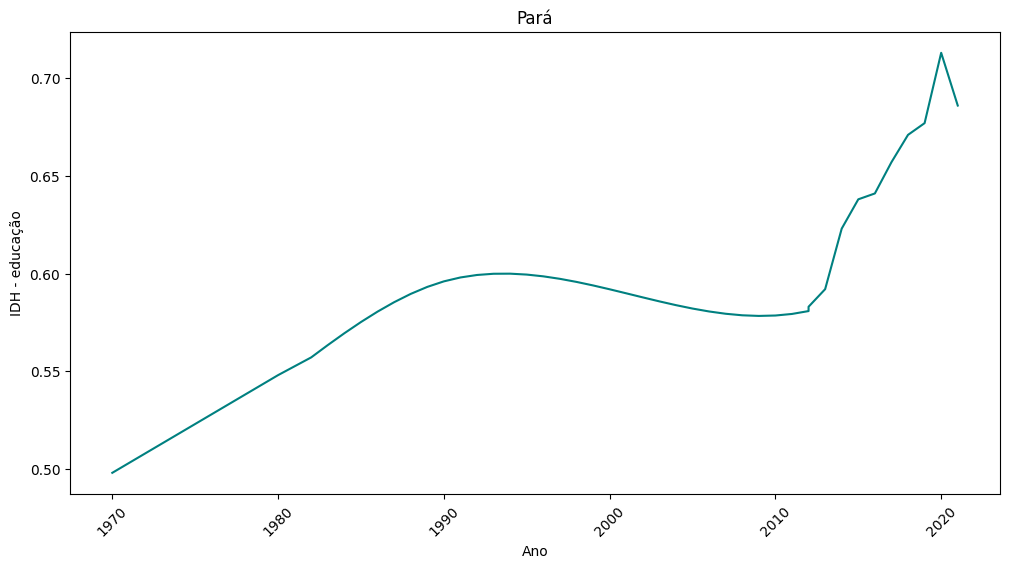

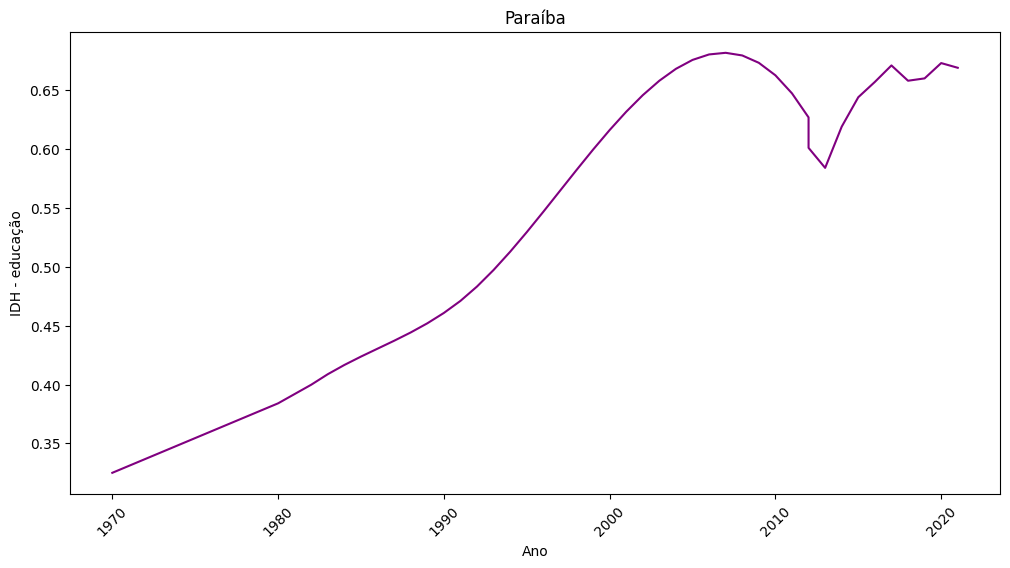

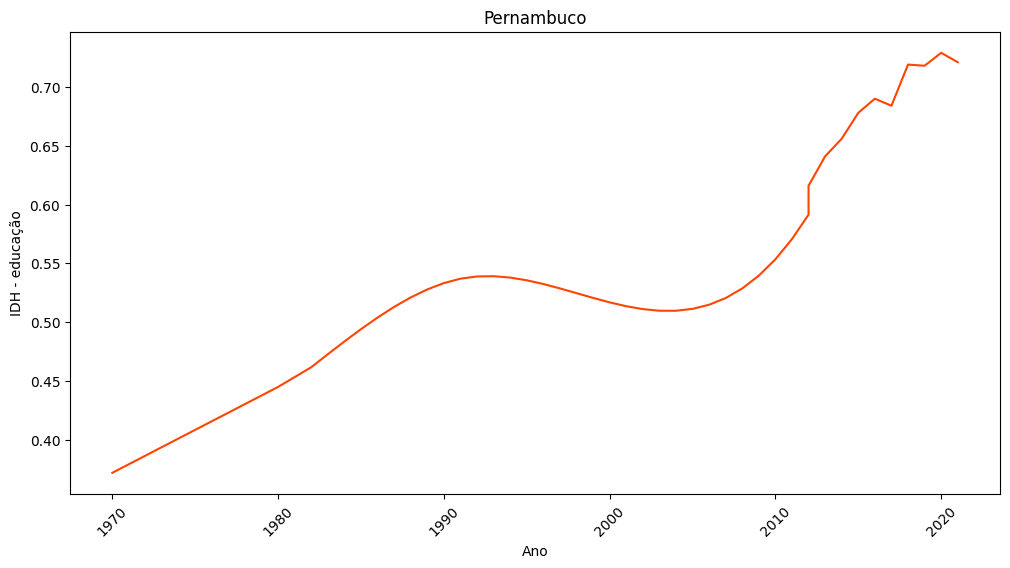

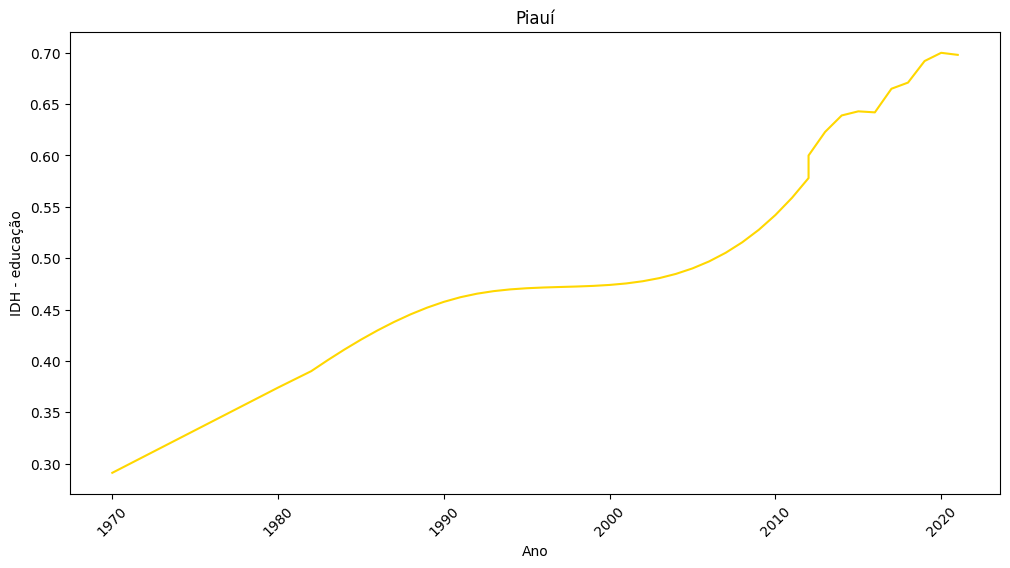

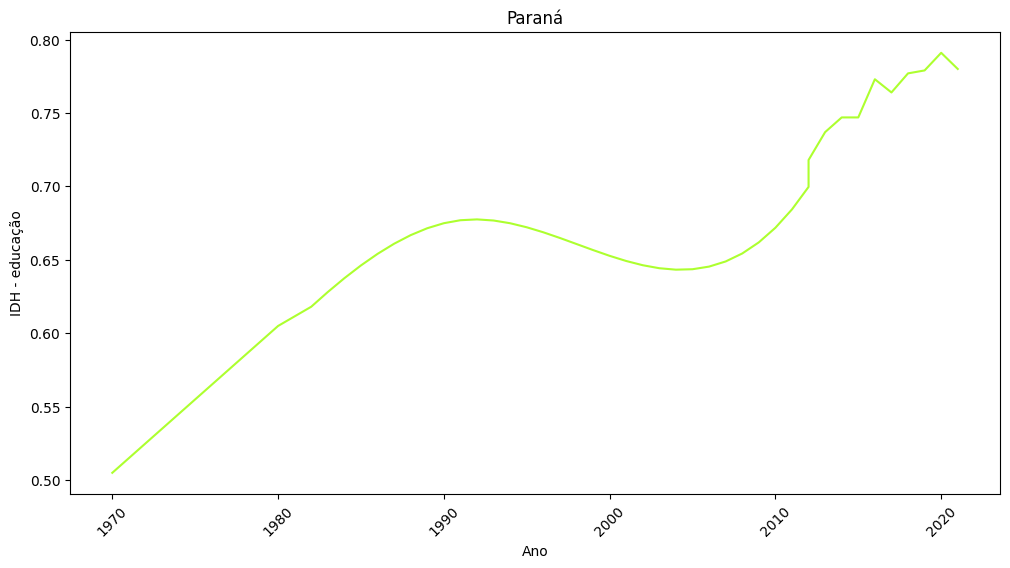

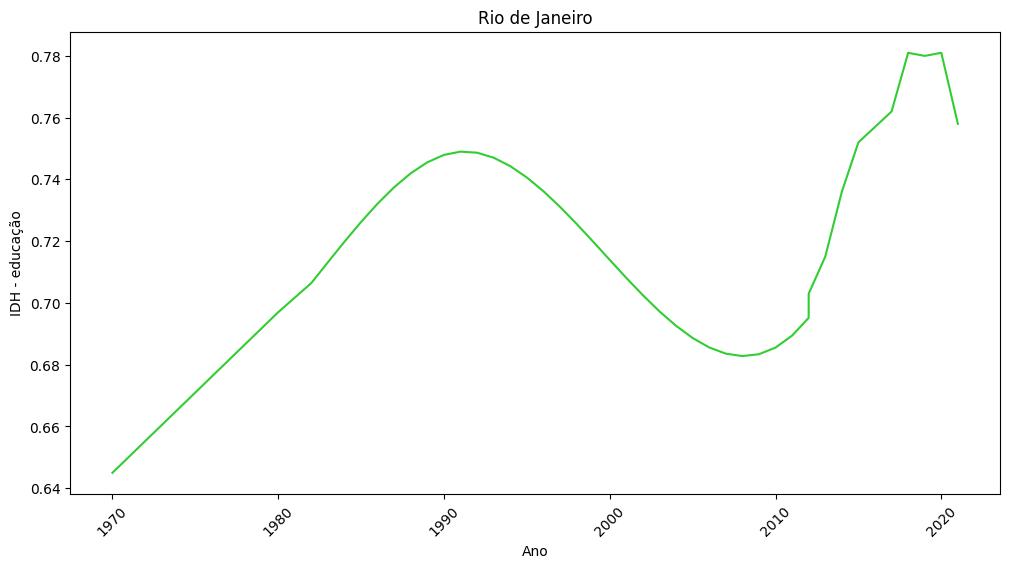

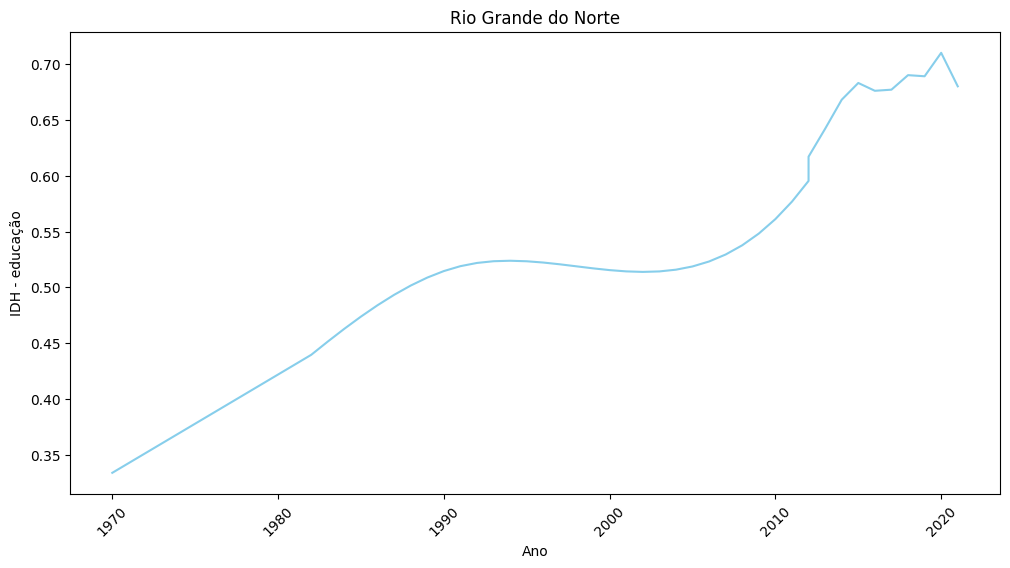

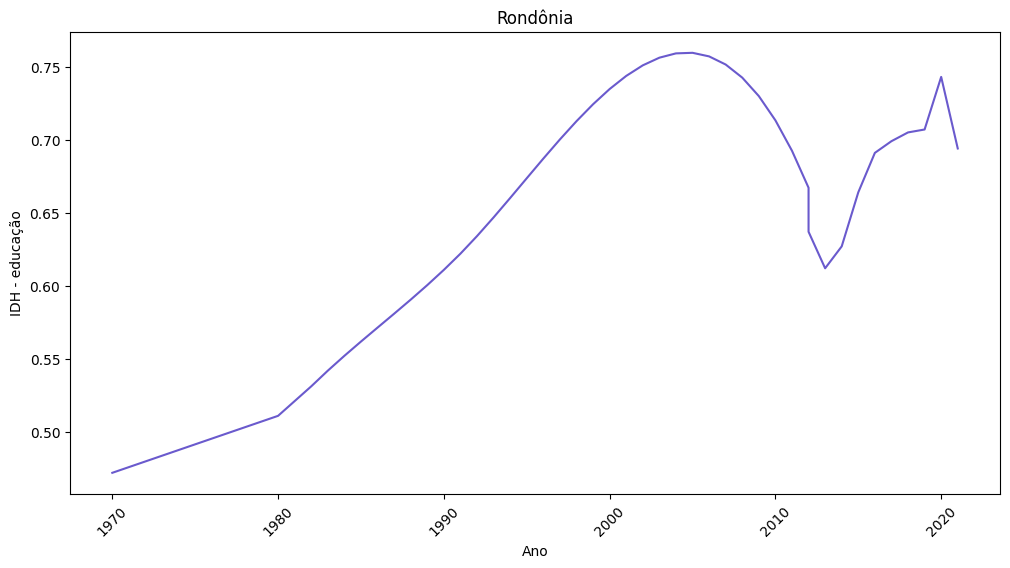

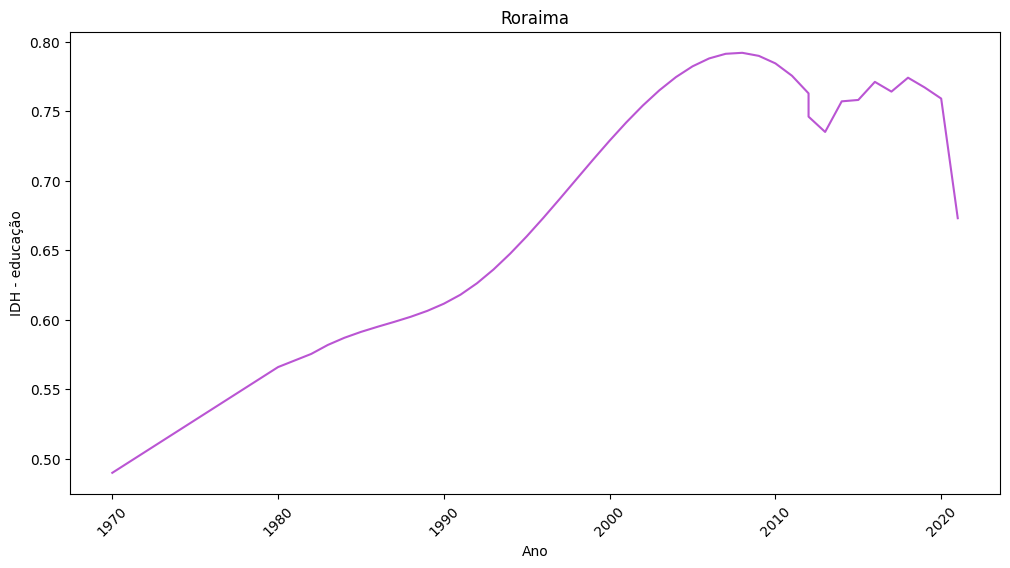

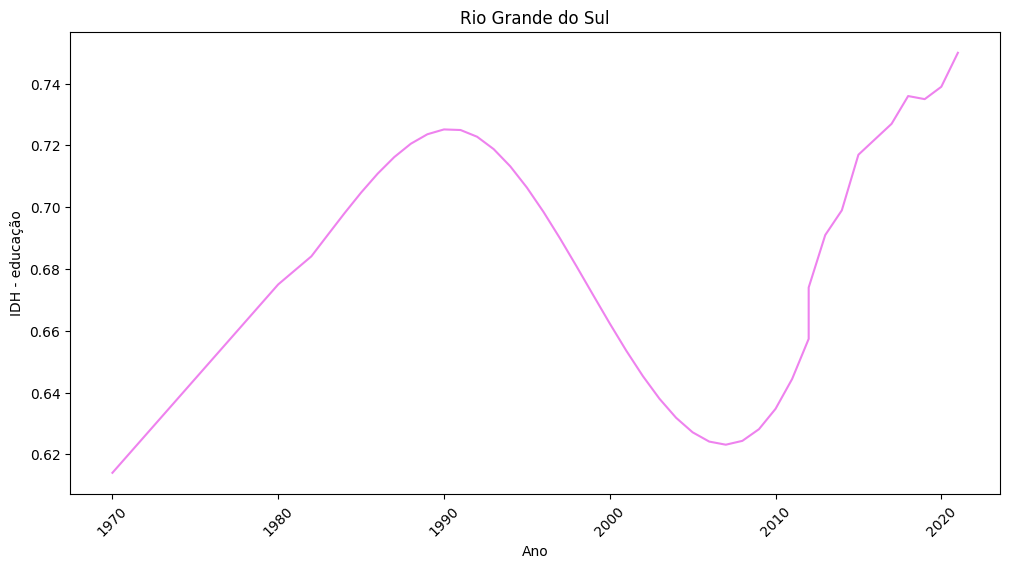

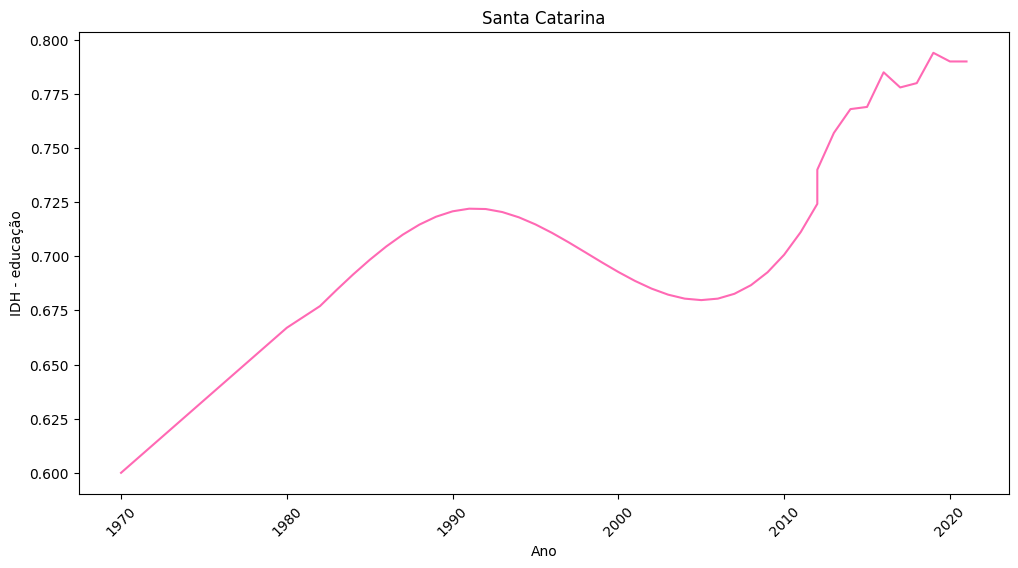

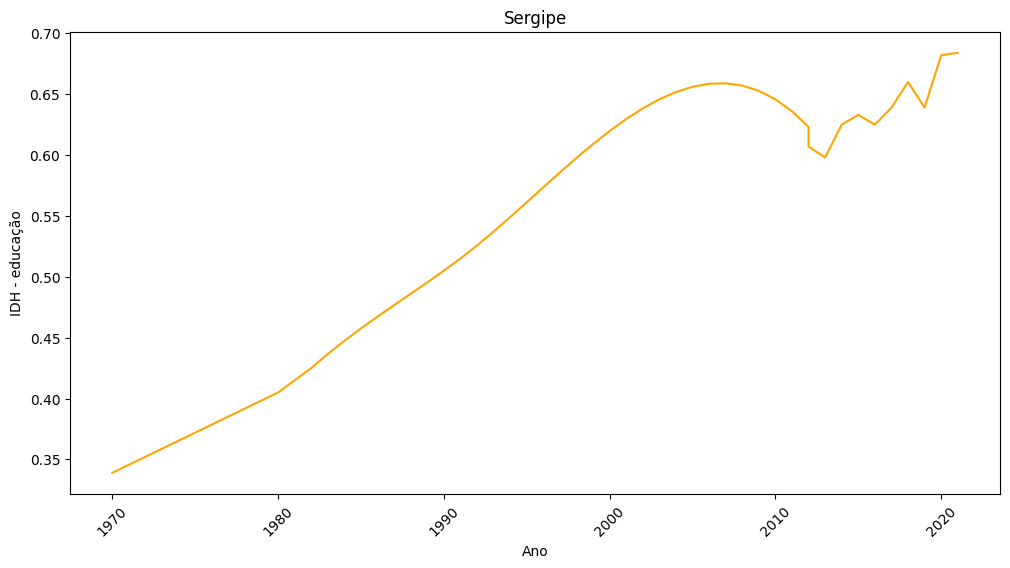

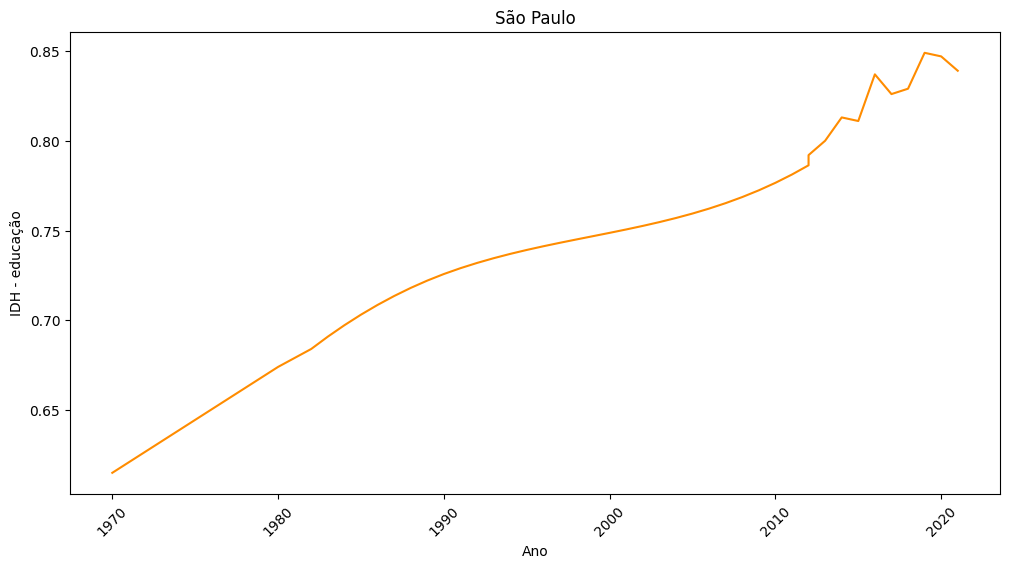

In [42]:
colors = ['#FF0000', '#FF7F00', '#FFFF00', '#00FF00', '#0000FF', '#4B0082', '#8B00FF', '#9400D3', '#FF00FF',
          '#00FFFF', '#008000', '#800000', '#808000', '#008080', '#800080', '#FF4500', '#FFD700', '#ADFF2F',
          '#32CD32', '#87CEEB', '#6A5ACD', '#BA55D3', '#EE82EE', '#FF69B4', '#FFA500', '#FF8C00', '#7FFFD4',
          '#00CED1']

for i, column in enumerate(df.columns):
    if i > 1:
        plot_column(df[column], color=colors[i])